<a href="https://colab.research.google.com/github/garrett-yoon/BMSC-GA-4493-Spring2021/blob/master/DenseNet_Feature_Vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 25 01:38:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
# Import packages and load model

import pandas as pd
import numpy as np
import torch
from torchvision import transforms, datasets
from torchsummary import summary
from pathlib import Path
import time

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# If True, will feature extract. If False, will FineTune
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
feature_extract = False

model_ft = torch.hub.load('pytorch/vision:v0.6.0', 'densenet121', pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = torch.nn.Linear(num_ftrs, 2)
input_size = 224
model_ft = model_ft.to(device)

# or any of these variants
# model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet169', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet201', pretrained=True)
# model = torch.hub.load('pytorch/vision:v0.6.0', 'densenet161', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
!unzip /content/chest_xray.zip

In [23]:
# Data Loading

#ImageNet Mean and Stdev
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
        'train': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        'val': transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

root = Path('/content/chest_xray')

#root = Path('/content/drive/MyDrive/pneumonia_chest_xray')
train_data = datasets.ImageFolder(root/'train', transform=data_transforms['train'])
test_data = datasets.ImageFolder(root/'test', transform=data_transforms['val'])

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                         shuffle=True, num_workers=1)


test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size,
                                         shuffle=True, num_workers=1)


In [ ]:
# Model Training
model_ft.train()

optimizer = torch.optim.SGD(model_ft.parameters(), lr = 0.0001)
criterion = torch.nn.CrossEntropyLoss()

epochs = 1
loss_lst = []
epoch_acc = []

for epoch in list(range(epochs)):
    t0 = time.time()
    epoch_loss = 0
    epoch_cor = 0
    for i, (images, labels) in enumerate(train_loader):
        # Origin shape: [64, 3, 224, 224] 
        # input_layer: 3 input channels
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)

        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # if i % 10 == 0:
        #     print("Epoch", epoch+1, "Done with batch", i+1)
        epoch_loss += loss.item()
        epoch_cor += torch.sum(preds == labels.data)
        print('Batch', i+1)

    loss_lst.append(epoch_loss / i)
    print(f'Epoch {epoch+1} Loss: {epoch_loss / i}')
    epoch_acc.append(epoch_cor.double() / len(train_data))
    print(epoch_acc[-1])
    print('Epoch Time: {} seconds'.format(time.time() - t0))

print("Finished Training")

In [26]:
X, Y = next(iter(train_loader))


In [24]:
if feature_extract == True:
    model_path = root/'model_fext.pkl'

    torch.save(model_ft, model_path)
else:
    model_path = root/'model_ft.pkl'
    torch.save(model_ft, model_path)

In [4]:
model_path = root/'model_ft.pkl'
model_ft = torch.load(model_path)

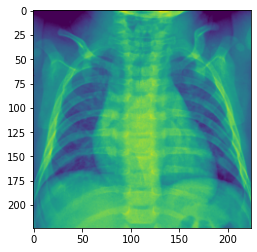

In [27]:
import matplotlib.pyplot as plt

plt.imshow(X[0].numpy()[0])

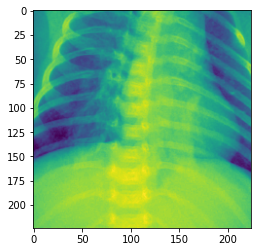

In [28]:
plt.imshow(X[1].numpy()[0])

In [29]:
import copy

class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

model_rev = copy.deepcopy(model_ft)
model_rev.classifier = Identity()
#model_rev.eval()

In [30]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_rev  = model_rev.cpu()
ft_output = model_rev(X)

ft_output.shape

torch.Size([64, 1024])

In [31]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

fvec1 = ft_output[0].unsqueeze(1)
fvec2 = ft_output[1].unsqueeze(1)
cos = torch.nn.CosineSimilarity(dim = 1, eps=1e-6)
cos_sim = cos(fvec1, fvec2)
cos_sim.shape

torch.Size([1024])

In [32]:
ft_output[1].shape

torch.Size([1024])

In [36]:
from scipy import spatial

result = 1 - spatial.distance.cosine(fvec1.detach().numpy(), fvec2.detach().numpy())
result

0.6249257326126099